# Introduction
Failed taxi orders present a significant challenge in the ride-hailing industry, leading to customer dissatisfaction and loss of revenue. This project aims to analyze failed orders in a corporate Ground Transportation Management (GTM) platform to identify patterns and causes behind order failures. By investigating cancellations before and after driver assignment, rejection reasons, and time-related trends, we seek to provide insights that can help reduce failed orders and improve matching efficiency. The objective is to develop a data-driven approach to minimize order cancellations and enhance the overall reliability of the system.

# About the Dataset
We have two data sets: **data_orders** and **data_offers**, both being stored in a CSV format. 

The data_orders data set contains the following columns:
* order_datetime - time of the order
* origin_longitude - longitude of the order
* origin_latitude - latitude of the order
* m_order_eta - time before order arrival
* order_gk - order number
* order_status_key - status, an enumeration consisting of the following mapping:
    * 4 - cancelled by client,
    * 9 - cancelled by system, i.e., a reject
* is_driver_assigned_key - whether a driver has been assigned
* cancellation_time_in_seconds - how many seconds passed before cancellation


The data_offers data set is a simple map with 2 columns:
* order_gk - order number, associated with the same column from the orders data set
* offer_id - ID of an offer

#### Importing Libraries

In [59]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

#### Data Exploration

In [60]:
path1 = 'data_offers.csv'
data_offers = pd.read_csv(path1)
path2 = 'data_orders.csv'
data_orders = pd.read_csv(path2)

In [61]:
data_off=data_offers.copy()
data_off.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [62]:
data_off.shape

(334363, 2)

In [63]:
data_odr = data_orders.copy()
data_odr.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [64]:
data_odr.shape

(10716, 8)

In [65]:
data_odr = data_odr.rename(columns = {
    'm_order_eta': 'time_to_arrival',
    'order_gk' : 'order_no',
    'order_status_key' : 'order_status',
    'is_driver_assigned_key' : 'driver_status',
    'cancellations_time_in_seconds' : 'cancellation_time(sec)'
    })
data_odr.head()

,order_datetime,origin_longitude,origin_latitude,time_to_arrival,order_no,order_status,driver_status,cancellation_time(sec)
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [66]:
data_off = data_off.rename(columns = {'order_gk' : 'order_no'})
data_off.head()

,order_no,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


#### Data Preprocessing

In [67]:
data_odr.isnull().sum()

order_datetime               0
origin_longitude             0
origin_latitude              0
time_to_arrival           7902
order_no                     0
order_status                 0
driver_status                0
cancellation_time(sec)    3409
dtype: int64

In [68]:
data_off.isnull().sum()

order_no    0
offer_id    0
dtype: int64

In [69]:
data_odr['time_to_arrival'] = data_odr['time_to_arrival'].fillna(data_odr['time_to_arrival'].median())

In [70]:
data_odr['cancellation_time(sec)'] = data_odr['cancellation_time(sec)'].fillna(data_odr['cancellation_time(sec)'].median())

In [71]:
data_odr.isnull().sum()

order_datetime            0
origin_longitude          0
origin_latitude           0
time_to_arrival           0
order_no                  0
order_status              0
driver_status             0
cancellation_time(sec)    0
dtype: int64

## 1. Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

In [72]:
quantity_count = data_odr.groupby('order_status')['driver_status'].count()
print(quantity_count)

order_status
4    7307
9    3409
Name: driver_status, dtype: int64


In [73]:
data = data_odr.groupby(['order_status','driver_status'])['driver_status'].count()
data

order_status  driver_status
4             0                4496
              1                2811
9             0                3406
              1                   3
Name: driver_status, dtype: int64

In [74]:
data_odr['driver_status_label'] = data_odr['driver_status'].replace({0: 'Before Driver Assigned', 1: 'After Driver Assigned'})
data_odr['order_status_label'] = data_odr['order_status'].replace({4: 'Cancelled by Client', 9: 'Cancelled by System'})

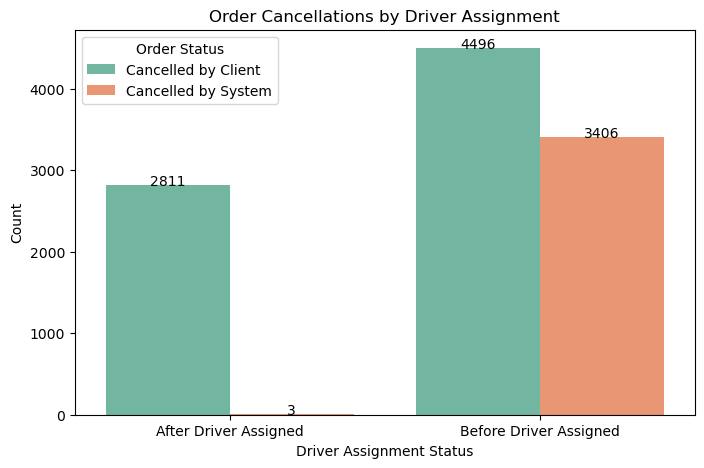

In [75]:
# Group by order and driver status for plotting
data = data_odr.groupby(['order_status_label', 'driver_status_label']).size().reset_index(name='count')

plt.figure(figsize=(8,5))
sns.barplot(data=data, x='driver_status_label', y='count', hue='order_status_label', palette='Set2')

for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

plt.title('Order Cancellations by Driver Assignment')
plt.xlabel('Driver Assignment Status')
plt.ylabel('Count')
plt.legend(title='Order Status')
plt.show()

### Observations and Analysis:

#### Distribution of Orders by Failure Reason:
1. **Cancelled by Client**:
   - **Before Driver Assigned**: This is the largest category with the highest number of orders (4496). It indicates that customers are more likely to cancel their orders before a driver is assigned.
   - **After Driver Assigned**: A significant number of cancellations (2811) happen after a driver has been assigned, suggesting that even after a match is made, customers might change their minds or face some issues, like delays.

2. **Cancelled by System**:
   - **Before Driver Assigned**: The system cancels most orders (3406) before assigning a driver, likely due to no available drivers in the area or other logistical issues.
   - **After Driver Assigned**: Only a very small number (3) of orders are rejected after a driver is assigned, indicating that once a match is made, the likelihood of system-driven failures is extremely low.

#### Key Insights:
- The **majority of failed orders** occur when the client cancels the order before a driver is assigned.
- The system also cancels a large number of orders before drivers are matched, but very rarely does it cancel after a driver is assigned.

#### Suggestions:
- **Customer Communication**: More real-time updates or incentives for clients could reduce cancellations before drivers are assigned.
- **Improve Driver Availability**: To reduce system cancellations, improving the availability of drivers during peak hours or in specific regions could help.


## 2. Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?*

C:\Users\DEll\AppData\Local\Temp\ipykernel_13836\2364873763.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_odr['order_datetime'] = pd.to_datetime(data_odr['order_datetime'])


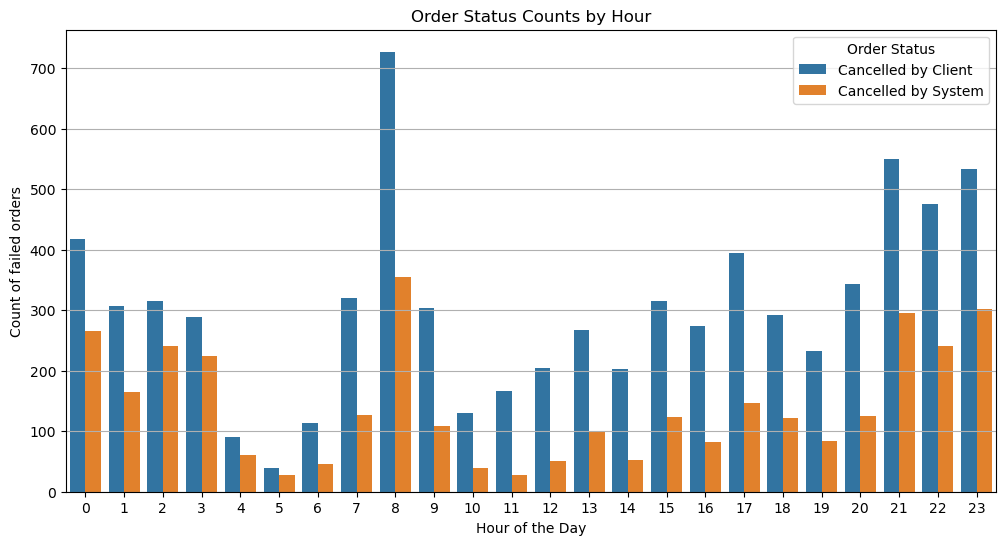

In [76]:
data_odr['order_datetime'] = pd.to_datetime(data_odr['order_datetime'])
data_odr['hour'] = data_odr['order_datetime'].dt.hour

data1 = data_odr.groupby(['order_status','hour']).agg(count=('order_status', 'size')).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=data1, x='hour', y='count', hue='order_status')

plt.title('Order Status Counts by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Count of failed orders')
plt.xticks(range(0, 24))

handles, labels = plt.gca().get_legend_handles_labels()
labels = ['Cancelled by Client' if label == '4' else 'Cancelled by System' for label in labels]
plt.legend(handles, labels,title='Order Status')
plt.grid(axis='y')

plt.show()

  hour_category  order_status  count
0     Afternoon             4   1265
1     Afternoon             9    408
2       Evening             4   1263
3       Evening             9    478
4       Morning             4   1801
5       Morning             9    729
6         Night             4   2978
7         Night             9   1794


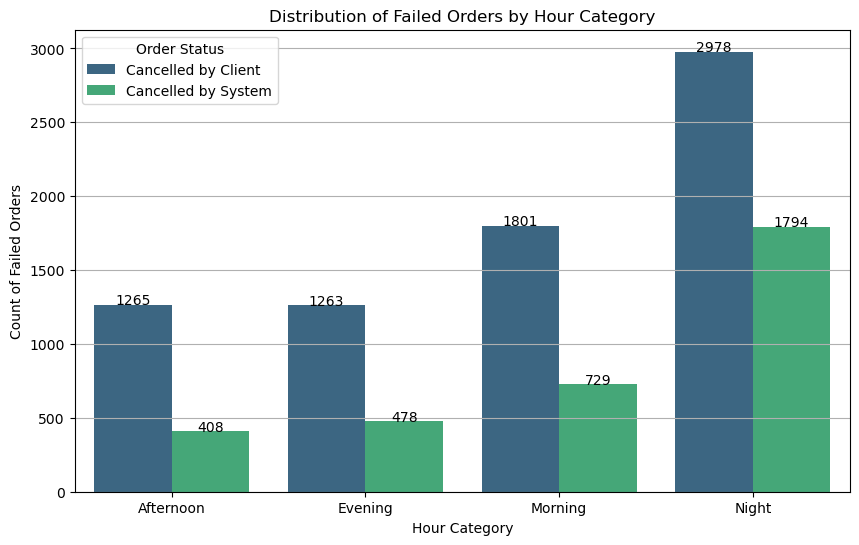

In [77]:
def categorize_hour(hour):
    if 5 <= hour < 12:
        return 'Morning'      
    elif 12 <= hour < 17:
        return 'Afternoon'    
    elif 17 <= hour < 21:
        return 'Evening'      
    else:
        return 'Night'        

data_odr['hour'] = pd.to_datetime(data_odr['order_datetime']).dt.hour
data_odr['hour_category'] = data_odr['hour'].apply(categorize_hour)

grouped_data = data_odr.groupby(['hour_category', 'order_status']).size().reset_index(name='count')
print(grouped_data)

plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_data, x='hour_category', y='count', hue='order_status', palette='viridis')

for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')


plt.title('Distribution of Failed Orders by Hour Category')
plt.xlabel('Hour Category')
plt.ylabel('Count of Failed Orders')

handles, labels = plt.gca().get_legend_handles_labels()
labels = ['Cancelled by Client' if label == '4' else 'Cancelled by System' for label in labels]
plt.legend(handles, labels, title='Order Status')
plt.grid(axis='y')

plt.show()

### Observations and Analysis:

1. **Highest Cancellations at Night**:
   - Night time has the most cancellations, with 2978 from clients and 1794 from the system. This shows that late hours have the most issues with completing orders.

2. **More Client Cancellations Than System Cancellations**:
   - In all time periods, clients cancel orders more often than the system. In the Morning and Afternoon, client cancellations are 2.5 to 3 times higher than system cancellations. At Night, client cancellations are still 1.6 times higher than system cancellations, but system issues are also more common.

3. **Clients Cancel More at Night**:
   - Clients are more likely to cancel orders late in the day, which could mean they are rethinking their decisions or making impulsive purchases they later regret.

4. **Nighttime Operational Issues**:
   - System cancellations are higher at night, which suggests there might be problems with order processing or fewer resources available to handle orders.

#### Key Insights :

- **Client Behavior**: People might be making more impulsive decisions at night, which leads to more cancellations.
  
- **Operational Efficiency**: There may be fewer staff or system issues at night, causing more system cancellations.

- **Customer Support**: Limited support at night might lead to more cancellations, as customers may not resolve their issues.

#### Suggestion:

Night time has the highest cancellation rates, especially from clients. It’s important to understand why clients cancel more at night and if operational problems are also contributing to this trend. Improving service during late hours could help reduce cancellations.

## 3. Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

In [78]:
data_odr['cancellation_time(sec)'].describe()

count    10716.000000
mean       138.839026
std        178.380541
min          3.000000
25%         67.000000
50%         98.000000
75%        139.000000
max       4303.000000
Name: cancellation_time(sec), dtype: float64

In [79]:
Q1 = data_odr['cancellation_time(sec)'].quantile(0.25)
Q3 = data_odr['cancellation_time(sec)'].quantile(0.75)
IQR = Q3 - Q1
IQR

72.0

In [80]:
# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
lower_bound

-41.0

In [81]:
upper_bound = Q3 + 1.5 * IQR
upper_bound

247.0

In [82]:
# Filter to remove outliers
filtered = data_odr[(data_odr['cancellation_time(sec)'] >= lower_bound) & 
                    (data_odr['cancellation_time(sec)'] <= upper_bound)].copy()
filtered.count()

order_datetime            9677
origin_longitude          9677
origin_latitude           9677
time_to_arrival           9677
order_no                  9677
order_status              9677
driver_status             9677
cancellation_time(sec)    9677
driver_status_label       9677
order_status_label        9677
hour                      9677
hour_category             9677
dtype: int64

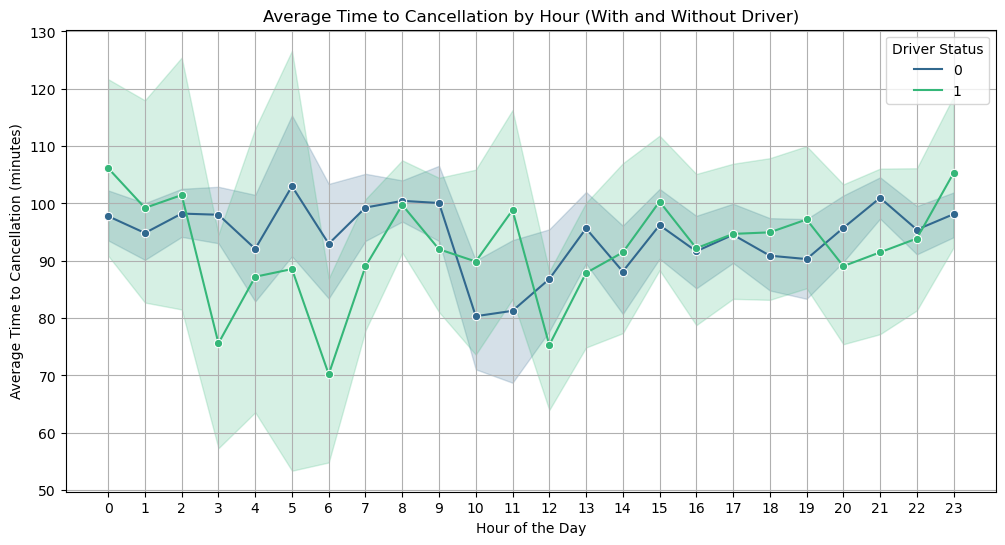

In [83]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered, x='hour', y='cancellation_time(sec)', hue='driver_status', marker='o', palette='viridis')
plt.title('Average Time to Cancellation by Hour (With and Without Driver)')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Time to Cancellation (minutes)')
plt.xticks(range(0, 24))
plt.grid()
plt.legend(title='Driver Status')
plt.show()

### Key Observations and Conclusion:
1. **General Trend**:
   - **Without Driver (Status 0)**: The average time to cancellation is generally lower, indicating quicker cancellations when no driver is assigned.
   - **With Driver (Status 1)**: The average time to cancellation is higher, suggesting that the presence of a driver delays cancellations.

2. **Hourly Peaks and Troughs**:
   - **Peak Hours for Cancellations Without Driver**: Around hour 5, there's a noticeable peak in cancellations without a driver. This could indicate early morning cancellations, possibly due to changes in customer plans or errors in early orders.
   - **Peak Hours for Cancellations With Driver**: Around hour 21, there's a significant peak in cancellations with a driver. This might be due to late-night orders being reconsidered or logistical challenges in fulfilling late orders.

3. **Impact of Driver Assignment**:
   - **Faster Cancellations Without Driver**: The quicker cancellation times without a driver suggest that customers are more likely to cancel orders that haven't been confirmed with a driver. 
   - **Delayed Cancellations With Driver**: The higher average cancellation times with a driver indicate that once a driver is assigned, customers are less likely to cancel immediately.

#### Suggestions :

1. **Improving Operational Efficiency**:
   - **Quick Driver Assignment**: Assign drivers faster to reduce cancellations. This can be done with better scheduling and tracking of available drivers.
   - **Managing Peak Hours**: Focus on reducing cancellations during high-cancellation times, like early morning or late night, by improving service during these hours.

2. **Understanding Customer Behavior**:
   - **Analyzing Customer Patterns**: Study why customers cancel more at certain times to understand their preferences. This can help in creating strategies that improve customer satisfaction.
   - **Better Communication**: Contact customers at peak cancellation times to reassure them, which may prevent cancellations.

3. **Improving Service**:
   - **Collecting Feedback**: Ask customers who cancel why they did so to identify common problems and make improvements.
   - **Offering Incentives**: Encourage customers to stick with their orders by offering discounts or loyalty rewards, which can help reduce cancellations.

By addressing these areas, businesses can operate more efficiently, understand customer behavior better, and lower cancellation rates.

## 4.	Plot the distribution of average ETA by hours. How can this plot be explained?

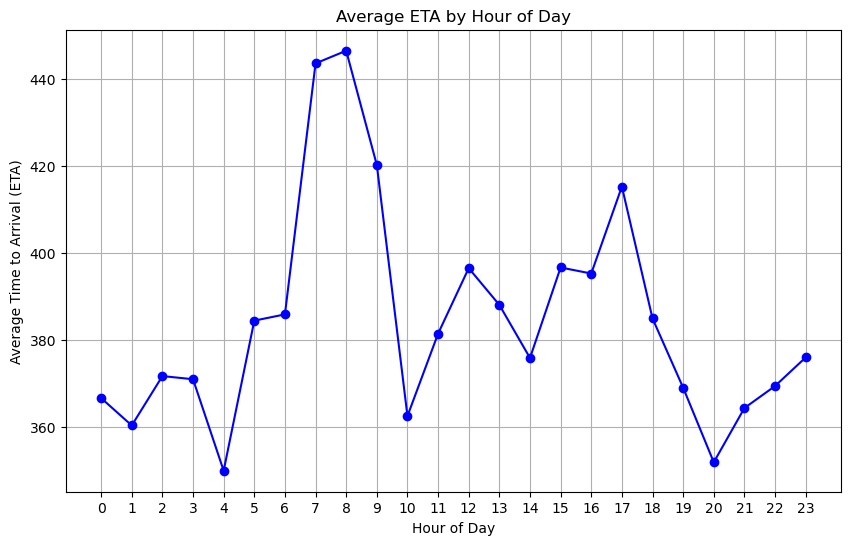

In [86]:
data_odr['order_datetime'] = pd.to_datetime(data_odr['order_datetime'])
data_odr['order_hour'] = data_odr['order_datetime'].dt.hour
avg_eta_by_hour = data_odr.groupby('order_hour')['time_to_arrival'].mean()

plt.figure(figsize=(10,6))
plt.plot(avg_eta_by_hour.index, avg_eta_by_hour.values, marker='o', linestyle='-', color='b')
plt.title('Average ETA by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Time to Arrival (ETA)')
plt.grid(True)
plt.xticks(range(24)) 
plt.show()

### Observations and Analysis:

* **High ETAs in the Morning**:
   - Between **6 AM and 9 AM**, there's a sharp increase in the **ETA** (Estimated Time of Arrival), peaking at around **8 AM**. This suggests that traffic or operational delays are significantly higher during early morning hours, possibly due to the morning rush hour.

* **Sudden Drop After 9 AM**:
   - After the morning peak, there's a sharp drop in the ETA around **10 AM**, suggesting that once the morning rush subsides, the delivery or travel times become much faster.

* **Fluctuations During the Afternoon**:
   - From **11 AM to 5 PM**, the ETA fluctuates, with noticeable peaks around **12 PM and 4 PM**. These fluctuations may correspond to periods of increased activity, such as lunchtime traffic or minor congestion spikes.

* **Another Peak in the Evening**:
   - There is another spike in ETA around **5 PM to 6 PM**, which could be attributed to the evening rush hour. This is typically the time when people are heading home, causing delays and increased travel times.

* **Low ETAs During Late Night**:
   - During the late-night and early morning hours, specifically after **9 PM**, the ETAs drop significantly, suggesting that travel or delivery times are faster due to reduced traffic and operational delays.

* **Overall Trend**:
   - The graph shows two main peaks in ETA: one in the **morning (6 AM - 9 AM)** and another in the **evening (5 PM - 6 PM)**, indicating the common congestion periods. The lowest ETAs are seen during the early morning hours and late-night hours.

#### Key Insights:

- **Peak Traffic Times**: The spikes in ETA during **rush hours (morning and evening)** suggest that delays are caused by increased traffic or operational bottlenecks at these times. 
- **Efficiency During Off-Peak Hours**: The lower ETAs during late night and midday hours indicate more efficient operations, possibly due to fewer vehicles on the road and lighter traffic conditions.

## 5.	BONUS Hexagons. Using the h3 and folium packages, calculate how many sizes 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

In [87]:
!pip install folium

In [88]:
!pip install h3

In [89]:
import h3
import folium

def create_hexagon_analysis(data_odr):
    """
    Create hexagon map analysis of failed orders using updated h3 API
    """
    
    def get_h3_index(row):
        return h3.latlng_to_cell(float(row['origin_latitude']), float(row['origin_longitude']), 8)  
    
    data_odr['h3_index'] = data_odr.apply(get_h3_index, axis=1)
    
    hex_counts = data_odr['h3_index'].value_counts()
    
    total_orders = hex_counts.sum()
    cumulative_counts = hex_counts.cumsum()
    hex_counts_80 = hex_counts[cumulative_counts <= total_orders * 0.8]
    center_lat = data_odr['origin_latitude'].mean()
    center_lon = data_odr['origin_longitude'].mean()
    
    m = folium.Map(location=[center_lat, center_lon], zoom_start=11)
    max_count = hex_counts_80.max()
    
    for h3_index in hex_counts_80.index:
        count = hex_counts_80[h3_index]
        boundaries = h3.cell_to_boundary(h3_index)
        boundary_coords = [[lat, lng] for lat, lng in boundaries]
        intensity = count / max_count
        folium.Polygon(
            locations=boundary_coords,
            popup=f'Failed Orders: {count}',
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=min(0.1 + intensity * 0.7, 0.9),
            weight=1
        ).add_to(m)
    
    return m, len(hex_counts_80)

data_odr['origin_latitude'] = data_odr['origin_latitude'].astype(float)
data_odr['origin_longitude'] = data_odr['origin_longitude'].astype(float)
map_obj, hex_count = create_hexagon_analysis(data_odr)
print(f"Number of hexagons containing 80% of failed orders: {hex_count}")
map_obj.save('failed_orders_heatmap.html')

Number of hexagons containing 80% of failed orders: 23


### Interpretation:

The output shows that **23 hexagons (size 8)** contain **80% of all failed orders**. This means that a large majority of the failed orders are concentrated in just a few specific areas on the map, represented by these hexagons.

#### What It Suggests for the Analysis:

1. **Geographic Concentration of Failures**: 
   - The failed orders are not spread evenly across the entire area. Instead, 80% of failures are concentrated in 23 specific regions (hexagons). These areas should be investigated further to understand why they experience such a high number of order failures.

2. **Focus on Key Areas**:
   - Since most failures are coming from a small number of regions, efforts to reduce order failures can be focused on these areas. This could mean improving delivery operations, customer service, or understanding specific challenges in these regions.

3. **Efficiency in Addressing Problems**:
   - By focusing on these 23 hexagons, businesses can target solutions (like better driver allocation or improved system support) where they will have the most impact, instead of spreading resources thin across the entire area.

In summary, the analysis suggests that businesses should focus their attention and resources on a few critical areas to significantly reduce the number of failed orders.